In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

import requests

from mpl_toolkits.basemap import Basemap
import matplotlib.patches as mpatches

import warnings
warnings.filterwarnings('ignore')

In [50]:
%load_ext watermark
%watermark -d -v -m -p numpy,pandas,matplotlib,scikit-learn

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
2017-04-20 

CPython 3.5.1
IPython 4.2.0

numpy 1.12.0
pandas 0.18.1
matplotlib 2.0.0
scikit-learn 0.18.1

compiler   : MSC v.1900 64 bit (AMD64)
system     : Windows
release    : 7
machine    : AMD64
processor  : Intel64 Family 6 Model 58 Stepping 9, GenuineIntel
CPU cores  : 4
interpreter: 64bit


In [51]:
berdo2015 = pd.read_csv(".//data/berdo2015.csv", encoding = "ISO-8859-1")
berdo2014 = pd.read_csv(".//data/berdo2014.csv", encoding = "ISO-8859-1")
berdo = pd.merge(berdo2015, berdo2014,
                 how='inner',
                 on=['Address','Property Name'],
                 suffixes=('_2015', '_2014'))
#berdo.to_csv(".\\data\\berdo.csv", index=False)

In [52]:
berdo = pd.read_csv(".\\data\\berdo.csv")

print(berdo.columns)

cols_num = ['Gross Area (sq ft)', 'Site EUI (kBTU/sf)',
            'GHG Emissions (MTCO2e)', 'GHG Intensity (kgCO2/sf)',
            ' Total Site Energy (kBTU) ','Water Intensity (gal/sf)'
           ]

cols_percent = ["% Gas", "% Steam", "% Electricity"]

def to_number(s):
    """Converts string s to a float.
    Returns -1 if error"""
    try:
        float(s)
        return float(s)
    except ValueError:
        return -1

def fix_numerical(columns):
    """Tranforms numerical columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            str(x).strip().replace(",","")
                                           )
            berdo[cyear] = berdo[cyear].map(to_number)
            cyear = c
            
def fix_percenteage(columns):
    """Tranforms percentage columns to number"""
    for c in columns:
        for year in ("_2014","_2015"):
            cyear = c + year
            berdo[cyear].fillna("0%", inplace=True)
            berdo[cyear] = berdo[cyear].map(lambda x:
                                            float(x.strip().replace("%",""))
                                           )         
            cyear = c

# transform columsn
fix_numerical(cols_num)
fix_percenteage(cols_percent)

berdo["%_total_2015"] = berdo[["% Gas_2015","% Steam_2015","% Electricity_2015"]].sum(axis=1)
berdo["%_total_2014"] = berdo[["% Gas_2014","% Steam_2014","% Electricity_2014"]].sum(axis=1)

# fix year built and crate decade
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: x+1000 if ((x < 1013) and (x > 800)) else x)
berdo["Year Built_2015"] = berdo["Year Built_2015"].map(lambda x: -1 if x <=800 else x)
berdo["decade"] = berdo["Year Built_2015"].map(lambda x: int(str(x)[:-1]+"0"))

Index(['Property Name', 'Reported_2015', 'Property Type_2015', 'Address',
       'ZIP_2015', 'Gross Area (sq ft)_2015', 'Site EUI (kBTU/sf)_2015',
       'Energy Star Score_2015', 'Energy Star Certified_2015',
       'Property Uses_2015', 'Year Built_2015', 'GHG Emissions (MTCO2e)_2015',
       'GHG Intensity (kgCO2/sf)_2015', ' Total Site Energy (kBTU) _2015',
       '% Electricity_2015', '% Gas_2015', '% Steam_2015',
       'Water Intensity (gal/sf)_2015', 'Onsite Solar (kWh)_2015',
       'User Submitted Info_2015', 'User Submitted Link_2015',
       'Tax Parcel_2015', 'Years Reported', 'Reported_2014',
       'Property Type_2014', 'ZIP_2014', 'Gross Area (sq ft)_2014',
       'Site EUI (kBTU/sf)_2014', 'Energy Star Score_2014',
       'Energy Star Certified_2014', 'Property Uses_2014', 'Year Built_2014',
       'GHG Emissions (MTCO2e)_2014', 'GHG Intensity (kgCO2/sf)_2014',
       ' Total Site Energy (kBTU) _2014', '% Electricity_2014', '% Gas_2014',
       '% Steam_2014', 'Water I

In [53]:
berdo = berdo[["Property Name","Address","ZIP_2015","Year Built_2015","decade",
               "Property Type_2015","Property Type_2014",
               "Gross Area (sq ft)_2015","Gross Area (sq ft)_2014",
               "Site EUI (kBTU/sf)_2015","Site EUI (kBTU/sf)_2014",
               " Total Site Energy (kBTU) _2015"," Total Site Energy (kBTU) _2014",
               "GHG Emissions (MTCO2e)_2015","GHG Emissions (MTCO2e)_2014",
               "GHG Intensity (kgCO2/sf)_2015","GHG Intensity (kgCO2/sf)_2014",
               "% Electricity_2015", "% Gas_2015", "% Steam_2015","%_total_2015",
               "% Electricity_2014", "% Gas_2014", "% Steam_2014","%_total_2014"
              ]]

### remove data that doesn't seem right. A deeper investigation should be done here
#print(berdo.isnull().sum())
print(berdo.shape)

print("---------")

# set values -1 to NaN
berdo.replace(-1,np.NaN,inplace=True)
# remove if total energy < 90. Check these deeper
berdo = berdo[(berdo["%_total_2015"] > 90) & (berdo["%_total_2014"] > 90)]
# drop all missing values
berdo.dropna(axis=0, how='any', inplace=True)
print(berdo.shape)

(1086, 25)
---------
(923, 25)


In [54]:
berdo_diff = pd.DataFrame()
berdo_diff[["property_name", "address","zip","year_built","decade"]] = berdo[["Property Name","Address","ZIP_2015","Year Built_2015","decade"]]
berdo_diff[["property_type_2015","property_type_2014"]] = berdo[["Property Type_2015","Property Type_2014"]]
berdo_diff["gloss_area_sqft"] = berdo["Gross Area (sq ft)_2015"]
berdo_diff["gloss_area_sqft_diff"] = berdo["Gross Area (sq ft)_2015"] - berdo["Gross Area (sq ft)_2014"]
berdo_diff["energy_kbtu/sf_diff"] = berdo["Site EUI (kBTU/sf)_2015"] - berdo["Site EUI (kBTU/sf)_2014"]
berdo_diff["energy_total_kbtu_diff"] = berdo[" Total Site Energy (kBTU) _2015"] - berdo[" Total Site Energy (kBTU) _2014"]
berdo_diff["ghg_emissions_mtco2e_diff"] = berdo["GHG Emissions (MTCO2e)_2015"] - berdo["GHG Emissions (MTCO2e)_2014"]
berdo_diff["ghg_intensity_kgco2/sf_diff"] = berdo["GHG Intensity (kgCO2/sf)_2015"] - berdo["GHG Intensity (kgCO2/sf)_2014"]
berdo_diff[["%_electricity_2015","%_gas_2015","%_steam_2015"]] = berdo[["% Electricity_2015","% Gas_2015","% Steam_2015"]]
berdo_diff[["%_electricity_2014","%_gas_2014","%_steam_2014"]] = berdo[["% Electricity_2014","% Gas_2014","% Steam_2014"]]

# quantiles
berdo_diff['energy_kbtu/sf_diff_Q'] = pd.qcut(berdo_diff['energy_kbtu/sf_diff'], 4,labels=False)
berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] = pd.qcut(berdo_diff['ghg_intensity_kgco2/sf_diff'], 4,labels=False)

In [12]:
import requests

def get_long_lat(address):
  
    fix_add = address.replace(" ","+")
    url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+Boston,+Massachusetts,+USA'
    try:        
        response = requests.get(url)
        resp_json_payload = response.json()
        #print(resp_json_payload)
        info = (resp_json_payload['results'][0]['geometry']['location'])
    except:
        return "0 0" 
            
    return (str(info['lat'])+" "+str(info['lng']))

berdo_diff["lat_long"] =  berdo_diff.address.map(get_long_lat)

In [13]:
#berdo_diff = pd.read_csv("./data/berdo_diff.csv")

def redo_long_lat(row):
    
    if row["lat_long"] == "0 0":
        address = row["address"]  
        fix_add = address.replace(" ","+")
        url = 'https://maps.googleapis.com/maps/api/geocode/json?address=' + fix_add + ',+Boston,+Massachusetts,+USA'
        try:        
            response = requests.get(url)
            resp_json_payload = response.json()
            #print(resp_json_payload)
            info = (resp_json_payload['results'][0]['geometry']['location'])
            return str(info['lat'])+" "+str(info['lng'])
        except:
            return "0 0" 
    else:
        return row["lat_long"]
        

berdo_diff["lat_long"] =  berdo_diff.apply(redo_long_lat, axis=1)

In [14]:
print(berdo_diff.lat_long.isnull().sum())
print(berdo_diff.lat_long.value_counts()[:5])

0
0 0                              12
42.3550045 -71.0567466            7
42.319977 -70.9659163             3
42.3393661 -71.09993589999999     3
42.3415836 -71.10358              3
Name: lat_long, dtype: int64


In [15]:
berdo_diff["lat"] = berdo_diff.lat_long.map(lambda x: float(x.split()[0]))
berdo_diff["long"] = berdo_diff.lat_long.map(lambda x: float(x.split()[1]))

In [31]:
berdo_diff.head(2)

,property_name,address,zip,year_built,property_type_2015,property_type_2014,gloss_area_sqft,gloss_area_sqft_diff,energy_kbtu/sf_diff,energy_total_kbtu_diff,ghg_emissions_mtco2e_diff,ghg_intensity_kgco2/sf_diff,lat_long,lat,long,energy_kbtu/sf_diff_Q,ghg_intensity_kgco2/sf_diff_Q
0,#2679 south bay/boston,5 alllstate road,02125,1998,Retail Store,Retail Store,132000.0,0.0,6.9,912943.0,47.5,0.4,42.327989 -71.063485,42.327989,-71.063485,3,3
1,0004 roslindale,950 american legion hgwy,02131,2001,Supermarket/Grocery Store,Supermarket/Grocery Store,38694.0,0.0,-2.8,-107313.0,-19.4,-0.5,42.27578219999999 -71.1142732,42.275782,-71.114273,1,0


In [ ]:
#berdo_diff.drop(["lat_long"],inplace=True)
berdo_diff.to_csv("./data/berdo_diff.csv", index=False)

1) Map with highest to lowest diff

2) avg/median diff by property type

3) avg/median diff by property zip code

4) avg/median diff by property decade built


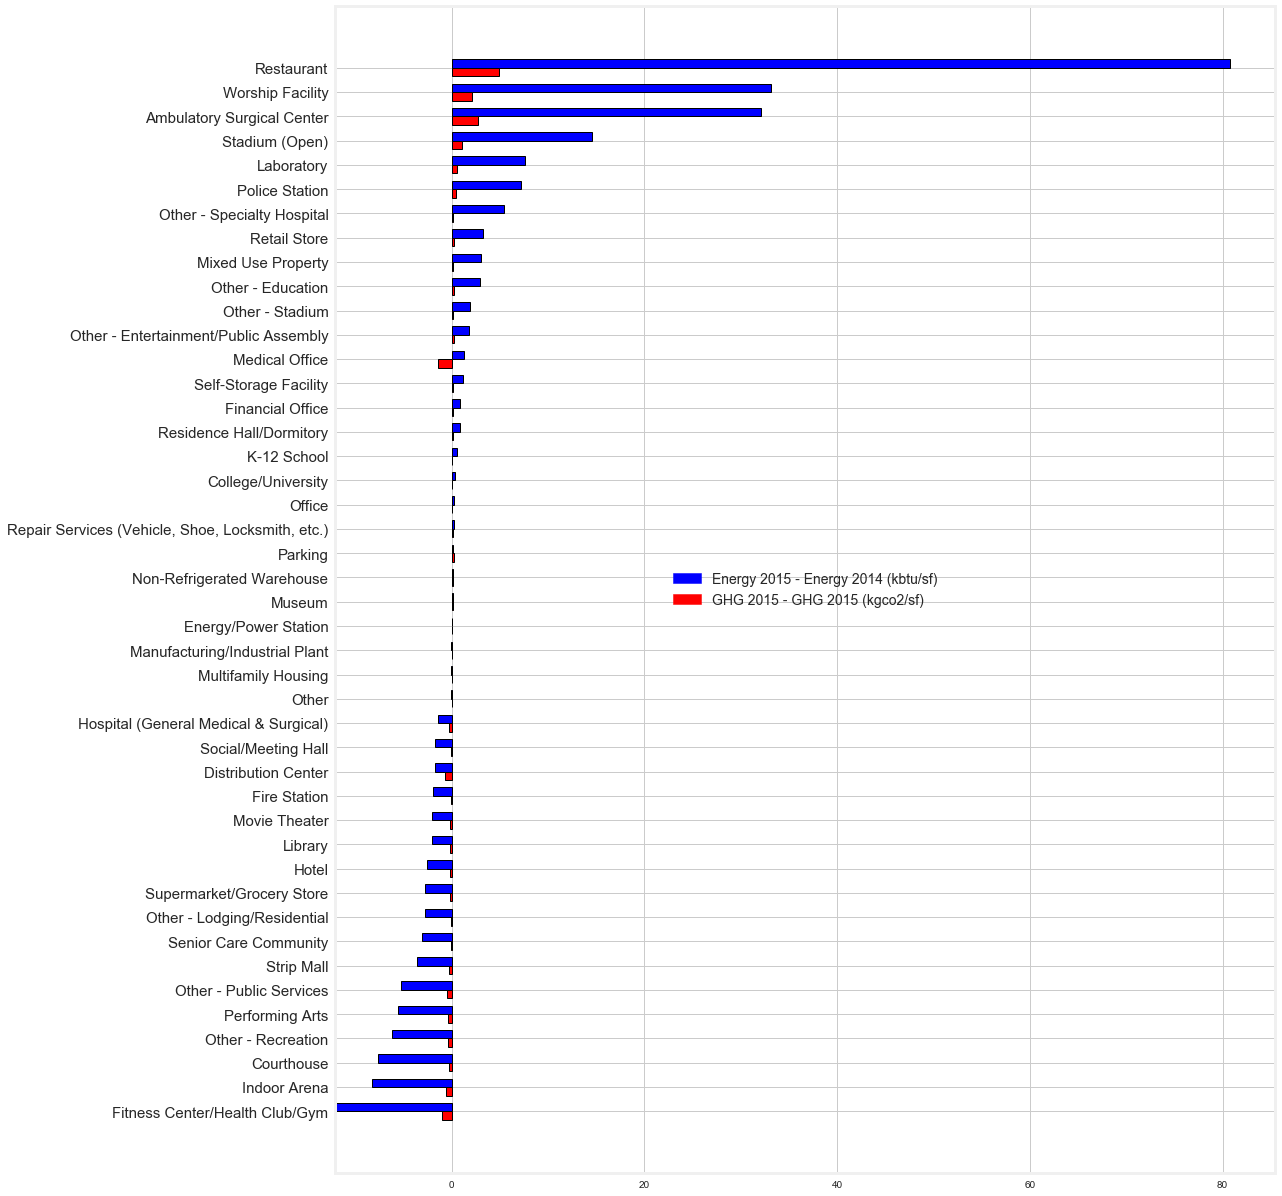

In [99]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

# plot 
plt.figure(figsize=(15, 20),facecolor='white')
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb,
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='center',
               prop={'size':14})

plt.show()

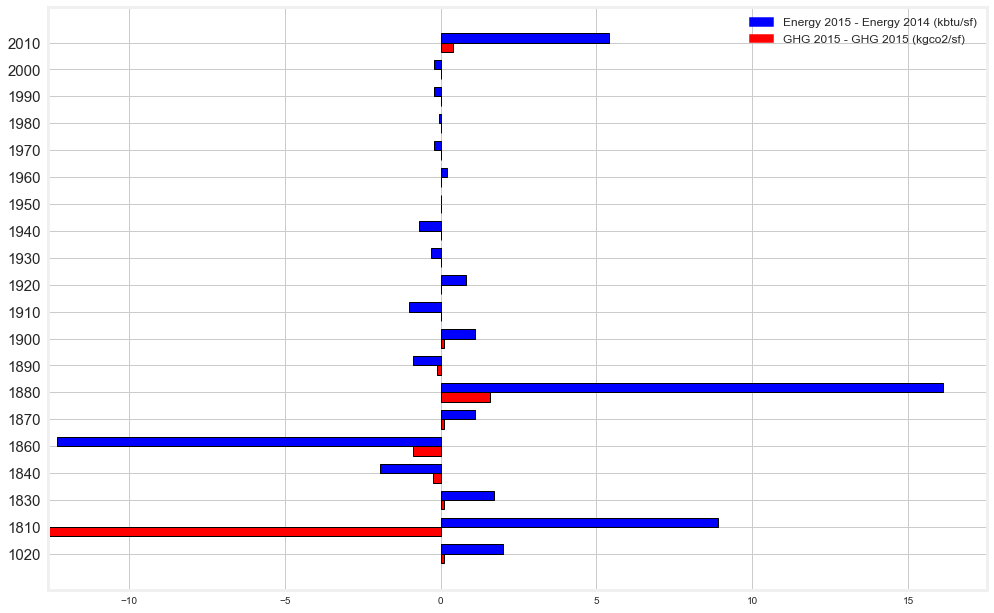

In [100]:
# data to plot
a = berdo_diff.groupby(["decade"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["decade"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_index()

# plot
plt.figure(figsize=(15, 10),
           facecolor='white')
ax=plt.subplot2grid((1,1), (0,0))

width = 0.35
ind = range(len(c.index))
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]
ax.barh(bottom=aa,
        width=c["energy_kbtu/sf_diff"].values,
        color="b", 
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.barh(bottom=bb, 
        width=c["ghg_intensity_kgco2/sf_diff"].values,
        color="r",
        align="center",
        edgecolor = "black",
        linewidth = 1,
        height=width)

ax.set_yticks(range(len(c.index)), [x for x in a.index])

ax.set_yticks([x+width/2 for x in ind])
ax.set_yticklabels([x for x in c.index], size=15)

# legend
import matplotlib.patches as mpatches
blue_patch = mpatches.Patch(color='blue',
                            label='Energy 2015 - Energy 2014 (kbtu/sf)')
red_patch = mpatches.Patch(color='red',
                           label='GHG 2015 - GHG 2015 (kgco2/sf)')

l = plt.legend(handles=[blue_patch,red_patch],
               loc='upper right',
               prop={'size':12})

plt.show()

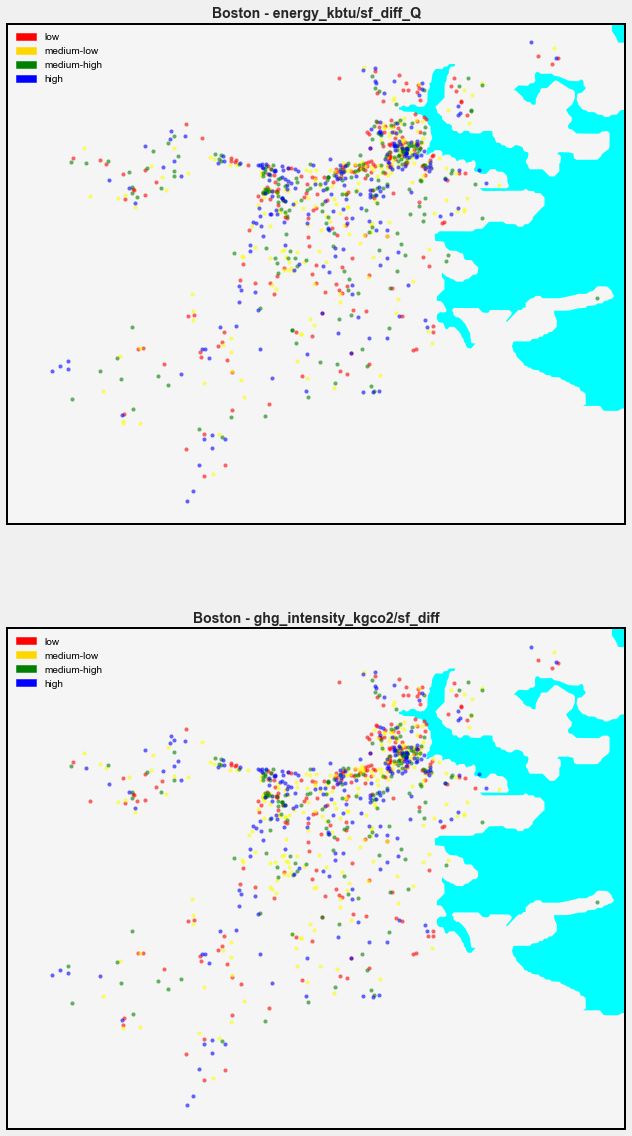

In [29]:
low = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 0]
medium_low = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 1]
medium_high = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 2]
high = berdo_diff[berdo_diff['energy_kbtu/sf_diff_Q'] == 3]

west, south, east, north = -71.1958, 42.2254, -70.9804, 42.40

fig = plt.figure(figsize=(9,17),
                 facecolor='white')

fig.add_subplot(211)
m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south,resolution='f')

m.fillcontinents(color='whitesmoke', lake_color='aqua')
m.drawmapboundary(color='black', linewidth=2, fill_color='aqua')
m.drawrivers(color="aqua")


m.plot(low["long"].values, low["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.6,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(medium_low["long"].values, medium_low["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.6,
       markeredgecolor='yellow',
       markeredgewidth=0.05) 


m.plot(medium_high["long"].values, medium_high["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.6,
       markeredgecolor='green',
       markeredgewidth=0.05) 


m.plot(high["long"].values, high["lat"].values,
       'bo', 
       markersize=4,
       color='blue',
       alpha=0.6,
       markeredgecolor='blue',
       markeredgewidth=0.05) 


plt.title("Boston - energy_kbtu/sf_diff_Q",fontweight = 'bold', size=14)

#legend
red_patch = mpatches.Patch(color='red', label='low')
yellow_patch = mpatches.Patch(color='gold', label='medium-low')
green_patch = mpatches.Patch(color='green', label='medium-high')
blue_patch = mpatches.Patch(color='blue', label='high')
l = plt.legend(handles=[red_patch,yellow_patch,green_patch,blue_patch])
for text in l.get_texts():
    text.set_color("black")

###########################

low = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 0]
medium_low = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 1]
medium_high = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 2]
high = berdo_diff[berdo_diff['ghg_intensity_kgco2/sf_diff_Q'] == 3]

fig.add_subplot(212)
m = Basemap(llcrnrlat=south, urcrnrlat=north, llcrnrlon=west,
            urcrnrlon=east, lat_ts=south, resolution='f')

m.fillcontinents(color='whitesmoke', lake_color='aqua')
m.drawmapboundary(color='black', linewidth=2, fill_color='aqua')
m.drawrivers(color="white")


m.plot(low["long"].values, low["lat"].values,
       'bo', 
       markersize=4,
       color='red',
       alpha=0.6,
       markeredgecolor='red',
       markeredgewidth=0.05) 


m.plot(medium_low["long"].values, medium_low["lat"].values,
       'bo', 
       markersize=4,
       color='yellow',
       alpha=0.6,
       markeredgecolor='yellow',
       markeredgewidth=0.06) 


m.plot(medium_high["long"].values, medium_high["lat"].values,
       'bo', 
       markersize=4,
       color='green',
       alpha=0.6,
       markeredgecolor='green',
       markeredgewidth=0.05) 


m.plot(high["long"].values, high["lat"].values,
       'bo', 
       markersize=4,
       color='blue',
       alpha=0.6,
       markeredgecolor='blue',
       markeredgewidth=0.05) 


plt.title("Boston - ghg_intensity_kgco2/sf_diff",fontweight = 'bold', size=14)

#legend
red_patch = mpatches.Patch(color='red', label='low')
yellow_patch = mpatches.Patch(color='gold', label='medium-low')
green_patch = mpatches.Patch(color='green', label='medium-high')
blue_patch = mpatches.Patch(color='blue', label='high')
l = plt.legend(handles=[red_patch,yellow_patch,green_patch,blue_patch])
for text in l.get_texts():
    text.set_color("black")

    
plt.tight_layout()    
plt.show()

In [ ]:
# data to plot
a = berdo_diff.groupby(["property_type_2015"])['energy_kbtu/sf_diff'].median()
a = a[a <1000].sort_values()
b = berdo_diff.groupby(["property_type_2015"])['ghg_intensity_kgco2/sf_diff'].median()
b = b[b <500].sort_values()
c = pd.concat([a, b], axis=1).sort_values("energy_kbtu/sf_diff")

In [44]:
berdo_diff['energy_kbtu/sf_diff'].value_counts().sort_index().iloc[:10]

-73068.5    1
-68938.7    1
-54104.6    1
-25287.5    1
-3396.2     1
-2277.8     1
-782.7      1
-292.9      1
-292.0      1
-227.3      1
Name: energy_kbtu/sf_diff, dtype: int64

In [46]:
berdo_diff['energy_kbtu/sf_diff'].value_counts().sort_index().iloc[-10:]

154.3      1
195.3      1
198.8      1
265.9      1
297.7      1
304.4      1
515.1      1
993.5      1
5599.4     1
25474.8    1
Name: energy_kbtu/sf_diff, dtype: int64

In [61]:
bad_energy_share

,%_electricity_2014,%_gas_2014,%_steam_2014,%_electricity_2015,%_gas_2015,%_steam_2015
106,89.0,0.0,11.0,1.0,0.0,99.0
123,52.0,48.0,0.0,6.0,94.0,0.0
152,37.0,63.0,0.0,0.0,100.0,0.0
278,48.0,52.0,0.0,19.0,81.0,0.0
379,100.0,0.0,0.0,100.0,0.0,0.0
704,81.0,19.0,0.0,48.0,52.0,0.0
939,1.0,99.0,0.0,2.0,98.0,0.0


In [60]:
bad_energy_share = berdo_diff[["%_electricity_2014","%_gas_2014","%_steam_2014",
                                "%_electricity_2015","%_gas_2015","%_steam_2015"]][berdo_diff['energy_kbtu/sf_diff'] > 200]

In [62]:
len(bad_energy_share)

7

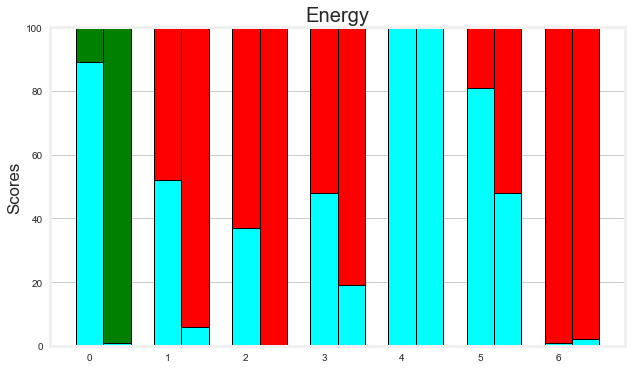

In [98]:
#stacked bars
aa=  [x+width for x in range(len(c.index))]
bb = [x for x in range(len(c.index))]

ind = np.arange(len(bad_energy_share))    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence


fig = plt.figure(figsize=(9,10),
                 facecolor='white')

fig.add_subplot(211)

p1 = plt.bar(ind,
             bad_energy_share["%_electricity_2014"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
p2 = plt.bar(ind,
             bad_energy_share["%_gas_2014"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             bottom= bad_energy_share["%_electricity_2014"])#, yerr=womenStd)
p3 = plt.bar(ind,
             bad_energy_share["%_steam_2014"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             bottom= bad_energy_share["%_electricity_2014"]+bad_energy_share["%_gas_2014"])

p1 = plt.bar(ind+width,
             bad_energy_share["%_electricity_2015"],
             width,
             align="center",
             color='aqua',
             edgecolor = "black",
             linewidth = 1)
             #bottom=[x+width for x in ind])#, yerr=menStd)
p2 = plt.bar(ind+width,
             bad_energy_share["%_gas_2015"], 
             width,
             align="center",
             color="red",
             edgecolor = "black",
             linewidth = 1,
             bottom= bad_energy_share["%_electricity_2015"])#, yerr=womenStd)
p3 = plt.bar(ind+width,
             bad_energy_share["%_steam_2015"],
             width,
             align="center",
             color='green',
             edgecolor = "black",
             linewidth = 1,
             bottom= bad_energy_share["%_electricity_2015"]+bad_energy_share["%_gas_2015"],)

#np.array(data1)+np.array(data2)

plt.ylabel('Scores')
plt.title('Energy')
#plt.xticks(ind, ('G1', 'G2', 'G3', 'G4', 'G5'))
#plt.yticks(np.arange(0, 81, 10))
#plt.legend((p1[0], p2[0]), ('Men', 'Women'))


plt.tight_layout()
plt.show()

In [ ]:
# lengend
# tickds